# Import Library

In [98]:
import findspark
findspark.init('/home/ubuntu/spark-3.2.1-bin-hadoop2.7')
import pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('operations').getOrCreate()

logger = spark._jvm.org.apache.log4j
logger.LogManager.getLogger("org").setLevel(logger.Level.ERROR)
logger.LogManager.getLogger("akka").setLevel(logger.Level.ERROR)

from pyspark.sql.functions import col,sum,count,countDistinct,min,max,regexp_replace,format_number,round,when,skewness,isnan

from pyspark.ml.stat import Correlation

from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.classification import (RandomForestClassifier, GBTClassifier, DecisionTreeClassifier)
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.evaluation import BinaryClassificationEvaluator

import seaborn as sns
import matplotlib.pyplot as plt

# Customise Methods

In [99]:
# Classification Report Method
def classification_report(predictions, label_col="cardio"):
    # Create evaluators
    evaluator = MulticlassClassificationEvaluator(labelCol=label_col, predictionCol="prediction")
    
    # Compute metrics
    precision_0 = evaluator.evaluate(predictions, {evaluator.metricName: "precisionByLabel", evaluator.metricLabel: 0})
    recall_0 = evaluator.evaluate(predictions, {evaluator.metricName: "recallByLabel", evaluator.metricLabel: 0})
    f1_0 = evaluator.evaluate(predictions, {evaluator.metricName: "f1", evaluator.metricLabel: 0})

    precision_1 = evaluator.evaluate(predictions, {evaluator.metricName: "precisionByLabel", evaluator.metricLabel: 1})
    recall_1 = evaluator.evaluate(predictions, {evaluator.metricName: "recallByLabel", evaluator.metricLabel: 1})
    f1_1 = evaluator.evaluate(predictions, {evaluator.metricName: "f1", evaluator.metricLabel: 1})

    accuracy = evaluator.evaluate(predictions, {evaluator.metricName: "accuracy"})
    
    # Compute support (number of occurrences of each class)
    support_0 = predictions.filter(predictions[label_col] == 0).count()
    support_1 = predictions.filter(predictions[label_col] == 1).count()

    # Print report
    print('              precision    recall  f1-score   support')
    print(f'           0  {precision_0:.2f}         {recall_0:.2f}    {f1_0:.2f}       {support_0}')
    print(f'           1  {precision_1:.2f}         {recall_1:.2f}    {f1_1:.2f}       {support_1}')
    print(f'    accuracy                       {accuracy:.2f}       {support_0 + support_1}')
    print(f'   macro avg  {(precision_0 + precision_1) / 2:.2f}         {(recall_0 + recall_1) / 2:.2f}    {(f1_0 + f1_1) / 2:.2f}       {support_0 + support_1}')
    print(f'weighted avg  {(precision_0 * support_0 + precision_1 * support_1) / (support_0 + support_1):.2f}         {(recall_0 * support_0 + recall_1 * support_1) / (support_0 + support_1):.2f}    {(f1_0 * support_0 + f1_1 * support_1) / (support_0 + support_1):.2f}       {support_0 + support_1}')


In [100]:
# Confusion Matrix Method    
def confusion_matrix(predictions, label_col="cardio", prediction_col="prediction"):
    # Count combinations of label and prediction
    confusion_matrix = predictions.groupBy(label_col, prediction_col).count().collect()

    # Extract counts from the DataFrame
    true_pos = true_neg = false_pos = false_neg = 0
    for row in confusion_matrix:
        if row[label_col] == 0 and row[prediction_col] == 0:
            true_neg = row['count']
        elif row[label_col] == 0 and row[prediction_col] == 1:
            false_pos = row['count']
        elif row[label_col] == 1 and row[prediction_col] == 0:
            false_neg = row['count']
        elif row[label_col] == 1 and row[prediction_col] == 1:
            true_pos = row['count']
    print(f"TN: {true_neg}\tFP: {false_pos}")
    print(f"FN: {false_neg}\tTP: {true_pos}")

In [101]:
# Feature Importance Method    
def feature_importance(model, feature_names):
    # Extract feature importances from the trained model
    importances = model.featureImportances

    # Map feature names to their importances and sort by importance
    features_with_importance = sorted(zip(feature_names, importances), key=lambda x: x[1], reverse=True)
    
    for feature, importance in features_with_importance:
        print(f"Feature: {feature}, Importance: {importance:.4f}")

# 1 - BU

The detial information about BU is addressed in Itertion-4 report Section - 1.

# 2- DU

In [102]:
# load the csv file
df = spark.read.csv('Datasets/heart_dataset_1.csv', inferSchema=True, header=True)

print(f"Total records: {df.count()}")

Total records: 69000


In [103]:
# Verify the loaded data
df.show()

+-----+---+-----+------+------+------+-----+-----+-----------+----+-----+----+------+------+
|index| id|  age|gender|height|weight|ap_hi|ap_lo|cholesterol|gluc|smoke|alco|active|cardio|
+-----+---+-----+------+------+------+-----+-----+-----------+----+-----+----+------+------+
|    0|  0|18393|     2|   168|  62.0|  110|   80|          1|   1|    0|   0|     1|     0|
|    1|  1|20228|     1|   156|  85.0|  140|   90|          3|   1|    0|   0|     1|     1|
|    2|  2|18857|     1|   165|  64.0|  130|   70|          3|   1|    0|   0|     0|     1|
|    3|  3|17623|     2|   169|  82.0|  150|  100|          1|   1|    0|   0|     1|     1|
|    4|  4|48Yrs|     1|   156|  56.0|  100|   60|          1|   1|    0|   0|     0|     0|
|    5|  8|21914|     1|   151|  67.0|  120|   80|          2|   2|    0|   0|     0|     0|
|    6|  9|22113|     1|   157|  93.0|  130|   80|          3|   1|    0|   0|     1|     0|
|    7| 12|22584|     2|   178|  95.0|  130|   90|          3|   3|   

In [104]:
# Verify the data schema
df.printSchema()

root
 |-- index: integer (nullable = true)
 |-- id: integer (nullable = true)
 |-- age: string (nullable = true)
 |-- gender: integer (nullable = true)
 |-- height: integer (nullable = true)
 |-- weight: double (nullable = true)
 |-- ap_hi: integer (nullable = true)
 |-- ap_lo: integer (nullable = true)
 |-- cholesterol: integer (nullable = true)
 |-- gluc: integer (nullable = true)
 |-- smoke: integer (nullable = true)
 |-- alco: integer (nullable = true)
 |-- active: integer (nullable = true)
 |-- cardio: integer (nullable = true)



In [105]:
df.columns

['index',
 'id',
 'age',
 'gender',
 'height',
 'weight',
 'ap_hi',
 'ap_lo',
 'cholesterol',
 'gluc',
 'smoke',
 'alco',
 'active',
 'cardio']

In [106]:
df.head(10)

[Row(index=0, id=0, age='18393', gender=2, height=168, weight=62.0, ap_hi=110, ap_lo=80, cholesterol=1, gluc=1, smoke=0, alco=0, active=1, cardio=0),
 Row(index=1, id=1, age='20228', gender=1, height=156, weight=85.0, ap_hi=140, ap_lo=90, cholesterol=3, gluc=1, smoke=0, alco=0, active=1, cardio=1),
 Row(index=2, id=2, age='18857', gender=1, height=165, weight=64.0, ap_hi=130, ap_lo=70, cholesterol=3, gluc=1, smoke=0, alco=0, active=0, cardio=1),
 Row(index=3, id=3, age='17623', gender=2, height=169, weight=82.0, ap_hi=150, ap_lo=100, cholesterol=1, gluc=1, smoke=0, alco=0, active=1, cardio=1),
 Row(index=4, id=4, age='48Yrs', gender=1, height=156, weight=56.0, ap_hi=100, ap_lo=60, cholesterol=1, gluc=1, smoke=0, alco=0, active=0, cardio=0),
 Row(index=5, id=8, age='21914', gender=1, height=151, weight=67.0, ap_hi=120, ap_lo=80, cholesterol=2, gluc=2, smoke=0, alco=0, active=0, cardio=0),
 Row(index=6, id=9, age='22113', gender=1, height=157, weight=93.0, ap_hi=130, ap_lo=80, cholestero

In [107]:
df.orderBy(df['Index'].asc()).show(10)

+-----+---+-----+------+------+------+-----+-----+-----------+----+-----+----+------+------+
|index| id|  age|gender|height|weight|ap_hi|ap_lo|cholesterol|gluc|smoke|alco|active|cardio|
+-----+---+-----+------+------+------+-----+-----+-----------+----+-----+----+------+------+
|    0|  0|18393|     2|   168|  62.0|  110|   80|          1|   1|    0|   0|     1|     0|
|    1|  1|20228|     1|   156|  85.0|  140|   90|          3|   1|    0|   0|     1|     1|
|    2|  2|18857|     1|   165|  64.0|  130|   70|          3|   1|    0|   0|     0|     1|
|    3|  3|17623|     2|   169|  82.0|  150|  100|          1|   1|    0|   0|     1|     1|
|    4|  4|48Yrs|     1|   156|  56.0|  100|   60|          1|   1|    0|   0|     0|     0|
|    5|  8|21914|     1|   151|  67.0|  120|   80|          2|   2|    0|   0|     0|     0|
|    6|  9|22113|     1|   157|  93.0|  130|   80|          3|   1|    0|   0|     1|     0|
|    7| 12|22584|     2|   178|  95.0|  130|   90|          3|   3|   

In [108]:
df.tail(10)

[Row(index=68990, id=98559, age='20508', gender=2, height=173, weight=91.0, ap_hi=140, ap_lo=90, cholesterol=1, gluc=1, smoke=0, alco=1, active=1, cardio=0),
 Row(index=68991, id=98561, age='21787', gender=1, height=168, weight=70.0, ap_hi=140, ap_lo=90, cholesterol=3, gluc=1, smoke=0, alco=0, active=1, cardio=1),
 Row(index=68992, id=98562, age='17574', gender=1, height=157, weight=63.0, ap_hi=150, ap_lo=100, cholesterol=1, gluc=1, smoke=0, alco=0, active=1, cardio=0),
 Row(index=68993, id=98563, age='14643', gender=2, height=175, weight=75.0, ap_hi=100, ap_lo=70, cholesterol=1, gluc=1, smoke=0, alco=0, active=1, cardio=0),
 Row(index=68994, id=98564, age='18949', gender=2, height=172, weight=62.0, ap_hi=110, ap_lo=70, cholesterol=1, gluc=1, smoke=1, alco=0, active=1, cardio=0),
 Row(index=68995, id=98565, age='17548', gender=2, height=173, weight=72.0, ap_hi=120, ap_lo=80, cholesterol=1, gluc=1, smoke=0, alco=0, active=0, cardio=0),
 Row(index=68996, id=98566, age='20430', gender=1, 

In [109]:
df.orderBy(df['Index'].desc()).show(10)

+-----+-----+-----+------+------+------+-----+-----+-----------+----+-----+----+------+------+
|index|   id|  age|gender|height|weight|ap_hi|ap_lo|cholesterol|gluc|smoke|alco|active|cardio|
+-----+-----+-----+------+------+------+-----+-----+-----------+----+-----+----+------+------+
|68999|98569|19591|     2|   175|  88.0|  120|   80|          1|   1|    0|   0|     0|     1|
|68998|98568|19107|     1|   154|  77.0|   14|   90|          1|   1|    0|   0|     1|     0|
|68997|98567|21682|     1|   158|  78.0|  130|   90|          1|   1|    0|   0|     1|     1|
|68996|98566|20430|     1|   159| 105.0|  120|   80|          1|   1|    0|   0|     1|     1|
|68995|98565|17548|     2|   173|  72.0|  120|   80|          1|   1|    0|   0|     0|     0|
|68994|98564|18949|     2|   172|  62.0|  110|   70|          1|   1|    1|   0|     1|     0|
|68993|98563|14643|     2|   175|  75.0|  100|   70|          1|   1|    0|   0|     1|     0|
|68992|98562|17574|     1|   157|  63.0|  150|  10

In [110]:
df.select('index','id').describe().show()

df.select('age','gender','height','weight').describe().show()

df.select('ap_hi','ap_lo','cholesterol','gluc').describe().show()

df.select('smoke','alco','active','cardio').describe().show()

+-------+------------------+------------------+
|summary|             index|                id|
+-------+------------------+------------------+
|  count|             69000|             69000|
|   mean|           34499.5| 49257.99002898551|
| stddev|19918.728624086427|28438.175895091368|
|    min|                 0|                 0|
|    max|             68999|             98569|
+-------+------------------+------------------+

+-------+------------------+-------------------+------------------+-----------------+
|summary|               age|             gender|            height|           weight|
+-------+------------------+-------------------+------------------+-----------------+
|  count|             69000|              69000|             69000|            69000|
|   mean|19469.362175167036| 1.3495217391304348|164.35059420289855|74.21126086956522|
| stddev|2467.2731299236907|0.47682238629511076| 8.211304686499416|14.40431106828465|
|    min|             10798|                  1|   

In [111]:
# Check for missing values in each column
missing_counts = df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns])
missing_counts.show()

+-----+---+---+------+------+------+-----+-----+-----------+----+-----+----+------+------+
|index| id|age|gender|height|weight|ap_hi|ap_lo|cholesterol|gluc|smoke|alco|active|cardio|
+-----+---+---+------+------+------+-----+-----+-----------+----+-----+----+------+------+
|    0|  0|  0|     0|     0|     0|    0|    0|          3|   0|    0|   0|     0|     0|
+-----+---+---+------+------+------+-----+-----+-----------+----+-----+----+------+------+



In [112]:
# Further analyse the "age" column
df.filter(~col("age").rlike("^[0-9]+$")).show()

+-----+-----+-----+------+------+------+-----+-----+-----------+----+-----+----+------+------+
|index|   id|  age|gender|height|weight|ap_hi|ap_lo|cholesterol|gluc|smoke|alco|active|cardio|
+-----+-----+-----+------+------+------+-----+-----+-----------+----+-----+----+------+------+
|    4|    4|48Yrs|     1|   156|  56.0|  100|   60|          1|   1|    0|   0|     0|     0|
|   28|   39|38Yrs|     2|   166|  66.0|  120|   80|          1|   1|    0|   0|     1|     0|
|23867|34120|44Yrs|     1|   161|  92.0|  906|    0|          2|   1|    0|   0|     1|     1|
+-----+-----+-----+------+------+------+-----+-----+-----------+----+-----+----+------+------+



In [113]:
# Further analyse the "ap_hi", "ap_lo", "heigh" and "weight"
df.select(min('ap_hi').alias('Min-ap_hi'), max('ap_hi').alias('Max-ap_hi')).show()
df.select(min('ap_lo').alias('Min-ap_lo'), max('ap_lo').alias('Max-ap_lo')).show()
df.select(min('height').alias('Min-Height'), max('height').alias('Max-Height')).show()
df.select(min('weight').alias('Min-Weight'), max('weight').alias('Max-weight')).show()

+---------+---------+
|Min-ap_hi|Max-ap_hi|
+---------+---------+
|     -150|    16020|
+---------+---------+

+---------+---------+
|Min-ap_lo|Max-ap_lo|
+---------+---------+
|      -70|    11000|
+---------+---------+

+----------+----------+
|Min-Height|Max-Height|
+----------+----------+
|        55|       250|
+----------+----------+

+----------+----------+
|Min-Weight|Max-weight|
+----------+----------+
|      10.0|     200.0|
+----------+----------+



In [114]:
# Further analyse the remaining attributes
df.select(countDistinct('gender'),countDistinct('cholesterol'),countDistinct('gluc'),countDistinct('smoke')).show()
df.select(countDistinct('alco'),countDistinct('active'),countDistinct('cardio')).show()

+----------------------+---------------------------+--------------------+---------------------+
|count(DISTINCT gender)|count(DISTINCT cholesterol)|count(DISTINCT gluc)|count(DISTINCT smoke)|
+----------------------+---------------------------+--------------------+---------------------+
|                     2|                          3|                   3|                    2|
+----------------------+---------------------------+--------------------+---------------------+

+--------------------+----------------------+----------------------+
|count(DISTINCT alco)|count(DISTINCT active)|count(DISTINCT cardio)|
+--------------------+----------------------+----------------------+
|                   2|                     2|                     2|
+--------------------+----------------------+----------------------+



In [115]:
df.select('gender').distinct().show()
df.select('cholesterol').distinct().show()
df.select('gluc').distinct().show()
df.select('smoke').distinct().show()
df.select('alco').distinct().show()
df.select('active').distinct().show()
df.select('cardio').distinct().show()

+------+
|gender|
+------+
|     1|
|     2|
+------+

+-----------+
|cholesterol|
+-----------+
|       null|
|          1|
|          3|
|          2|
+-----------+

+----+
|gluc|
+----+
|   1|
|   3|
|   2|
+----+

+-----+
|smoke|
+-----+
|    1|
|    0|
+-----+

+----+
|alco|
+----+
|   1|
|   0|
+----+

+------+
|active|
+------+
|     1|
|     0|
+------+

+------+
|cardio|
+------+
|     1|
|     0|
+------+



In [116]:
# 'Cardio vs Gender'
df.groupBy('cardio', 'gender').agg(count('*').alias('Count')).show()

+------+------+-----+
|cardio|gender|Count|
+------+------+-----+
|     1|     2|12195|
|     1|     1|22286|
|     0|     1|22597|
|     0|     2|11922|
+------+------+-----+



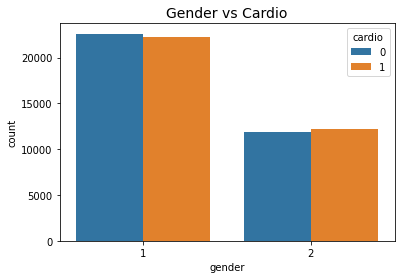

In [117]:
# Plotting 'Cardio vs Gender'
df_pd = df.toPandas()
sns.countplot(x='gender', hue='cardio', data=df_pd)
plt.title("Gender vs Cardio", size=14)
plt.show()

In [118]:
df.groupBy('cardio','active').agg(count('*').alias('Count')).show()

df.groupBy('cardio', 'smoke').agg(count('*').alias('Count')).show()

df.groupBy('cardio', 'alco').agg(count('*').alias('Count')).show()

+------+------+-----+
|cardio|active|Count|
+------+------+-----+
|     1|     0| 7239|
|     1|     1|27242|
|     0|     0| 6282|
|     0|     1|28237|
+------+------+-----+

+------+-----+-----+
|cardio|smoke|Count|
+------+-----+-----+
|     1|    0|31590|
|     1|    1| 2891|
|     0|    0|31318|
|     0|    1| 3201|
+------+-----+-----+

+------+----+-----+
|cardio|alco|Count|
+------+----+-----+
|     1|   0|32688|
|     1|   1| 1793|
|     0|   0|32602|
|     0|   1| 1917|
+------+----+-----+



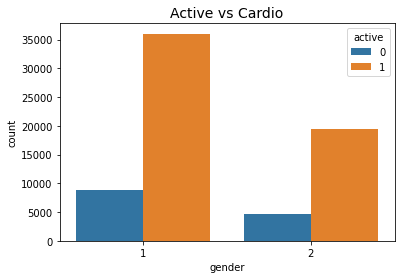

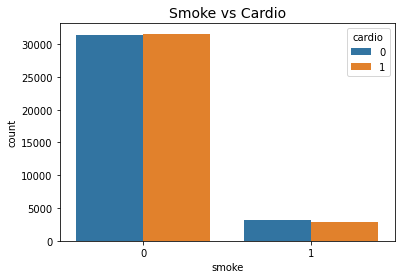

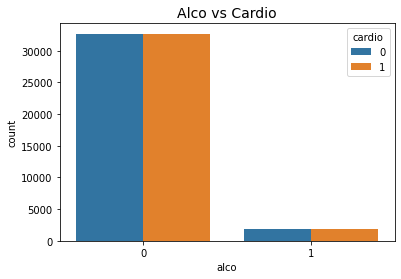

In [119]:
# Plotting 'Cardio vs active'
sns.countplot(x='gender', hue='active', data=df_pd)
plt.title("Active vs Cardio", size=14)
plt.show()

# Plotting 'Cardio vs active'
df_pd = df.toPandas()
sns.countplot(x='smoke', hue='cardio', data=df_pd)
plt.title("Smoke vs Cardio", size=14)
plt.show()

# Plotting 'Cardio vs active'
df_pd = df.toPandas()
sns.countplot(x='alco', hue='cardio', data=df_pd)
plt.title("Alco vs Cardio", size=14)
plt.show()

# 3 - DP

In [120]:
# prepare the columns and "age" column cannot correlation yet due to inconsistent data format
tmpDf = df.drop("age", "cardio")
columns = tmpDf.columns
target = 'cardio'

# apply correlation method
correlations = {}
for col in columns:
    corr_value = df.stat.corr(col, target)
    correlations[col] = corr_value

# print the result in descending order
print("\nCorrelation Results")
print("------------------------------------")
sorted_correlations = sorted(correlations.items(), key=lambda x: x[1], reverse=True)
for col, corr_value in sorted_correlations:
    print(f"Correlation between \"{target}\" and \"{col}\": {corr_value:.4f}")


Correlation Results
------------------------------------
Correlation between "cardio" and "cholesterol": 0.2215
Correlation between "cardio" and "weight": 0.1814
Correlation between "cardio" and "gluc": 0.0882
Correlation between "cardio" and "ap_lo": 0.0656
Correlation between "cardio" and "ap_hi": 0.0541
Correlation between "cardio" and "gender": 0.0087
Correlation between "cardio" and "index": 0.0040
Correlation between "cardio" and "id": 0.0040
Correlation between "cardio" and "alco": -0.0078
Correlation between "cardio" and "height": -0.0109
Correlation between "cardio" and "smoke": -0.0157
Correlation between "cardio" and "active": -0.0352


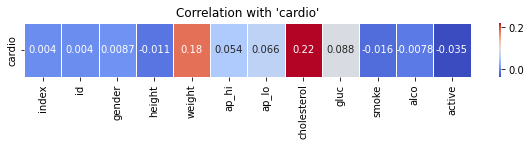

In [121]:
# preparing data to plot the heatmap diagram
attributes = list(correlations.keys())
correlation_values = list(correlations.values())
corr_matrix = [correlation_values]

# Generate the heatmap plot
plt.figure(figsize=(10, 1))  # Adjust size as per your preference
sns.heatmap(corr_matrix, annot=True, yticklabels=['cardio'], xticklabels=attributes, cmap="coolwarm", cbar=True, linewidths=0.5)
plt.title("Correlation with 'cardio'")
plt.show()

In [122]:
# drop the "Index" and "Id" columns
df= df.drop("Index", "Id")

df.columns

['age',
 'gender',
 'height',
 'weight',
 'ap_hi',
 'ap_lo',
 'cholesterol',
 'gluc',
 'smoke',
 'alco',
 'active',
 'cardio']

In [123]:
# drop the missing value rows
df= df.na.drop()

df.select('cholesterol').distinct().show()

+-----------+
|cholesterol|
+-----------+
|          1|
|          3|
|          2|
+-----------+



In [124]:
# handle data errors and extreme outlier
df = df.filter(
    ~(
        (df.ap_hi < 40) |
        (df.ap_hi > 370) |
        (df.ap_lo < 40) |
        (df.ap_lo > 370) |        
        (df.height < 145) |
        (df.weight < 45)
    )
)

df.select('ap_hi','ap_lo','height','weight').describe().show()

+-------+------------------+-----------------+------------------+------------------+
|summary|             ap_hi|            ap_lo|            height|            weight|
+-------+------------------+-----------------+------------------+------------------+
|  count|             67181|            67181|             67181|             67181|
|   mean|126.64908232982539|  81.412795284381|164.56456438576384| 74.28256426668254|
| stddev|16.728044719625508|9.671091681265171| 7.702318486155489|14.150908077532737|
|    min|                60|               40|               145|              45.0|
|    max|               240|              190|               250|             200.0|
+-------+------------------+-----------------+------------------+------------------+



In [125]:
# handle inconsistence data format

## filter out the year format data
df_filtered = df.filter(df["age"].like("%Yrs%"))
df_filtered.show()

+-----+------+------+------+-----+-----+-----------+----+-----+----+------+------+
|  age|gender|height|weight|ap_hi|ap_lo|cholesterol|gluc|smoke|alco|active|cardio|
+-----+------+------+------+-----+-----+-----------+----+-----+----+------+------+
|48Yrs|     1|   156|  56.0|  100|   60|          1|   1|    0|   0|     0|     0|
|38Yrs|     2|   166|  66.0|  120|   80|          1|   1|    0|   0|     1|     0|
+-----+------+------+------+-----+-----+-----------+----+-----+----+------+------+



In [126]:
## correction of age format
df_Correction = df_filtered.withColumn("age", regexp_replace(df["age"], "Yrs", "") * 365)
df_Correction.show()

+-------+------+------+------+-----+-----+-----------+----+-----+----+------+------+
|    age|gender|height|weight|ap_hi|ap_lo|cholesterol|gluc|smoke|alco|active|cardio|
+-------+------+------+------+-----+-----+-----------+----+-----+----+------+------+
|17520.0|     1|   156|  56.0|  100|   60|          1|   1|    0|   0|     0|     0|
|13870.0|     2|   166|  66.0|  120|   80|          1|   1|    0|   0|     1|     0|
+-------+------+------+------+-----+-----+-----------+----+-----+----+------+------+



In [127]:
## adding back to orginal dataframe and drop the inconsistant format

df = df.filter(~(df["age"].like("%Yrs%")))

df = df.union(df_Correction)

df.filter(df["age"].like("%Yrs%")).show()

+---+------+------+------+-----+-----+-----------+----+-----+----+------+------+
|age|gender|height|weight|ap_hi|ap_lo|cholesterol|gluc|smoke|alco|active|cardio|
+---+------+------+------+-----+-----+-----------+----+-----+----+------+------+
+---+------+------+------+-----+-----+-----------+----+-----+----+------+------+



In [128]:
# Count occurrences of each row
df_grouped = df.groupBy(df.columns).agg(count("*").alias("count"))

# Check for duplicates
if df_grouped.filter("`count` > 1").count() > 0:
    print(f"DataFrame has duplicate rows! - {df_grouped.filter('count > 1').count()} rows")
else:
    print("DataFrame does not have duplicate rows!")


DataFrame has duplicate rows! - 24 rows


In [129]:
# drop the duplicates row
df = df.dropDuplicates()

# Count occurrences of each row
df_grouped = df.groupBy(df.columns).agg(count("*").alias("count"))

# Check for duplicates
if df_grouped.filter("`count` > 1").count() > 0:
    print(f"DataFrame has duplicate rows! - {df_grouped.filter('count > 1').count()} rows")
else:
    print("DataFrame does not have duplicate rows!")

DataFrame does not have duplicate rows!


In [130]:
# adding new feature "BMI"
df = df.withColumn("BMI", round(df["weight"] / ((df["height"]/100) ** 2),2))

df.show()

+-----+------+------+------+-----+-----+-----------+----+-----+----+------+------+-----+
|  age|gender|height|weight|ap_hi|ap_lo|cholesterol|gluc|smoke|alco|active|cardio|  BMI|
+-----+------+------+------+-----+-----+-----------+----+-----+----+------+------+-----+
|20631|     1|   162|  85.0|  120|   70|          3|   3|    0|   0|     1|     1|32.39|
|21966|     1|   159| 101.0|  170|   90|          1|   1|    0|   0|     1|     1|39.95|
|23638|     1|   165|  60.0|  120|   80|          1|   1|    0|   0|     0|     1|22.04|
|23544|     2|   165|  67.0|  120|   80|          1|   1|    0|   0|     1|     0|24.61|
|17371|     1|   156|  74.0|  150|   90|          1|   1|    0|   0|     0|     1|30.41|
|20641|     1|   163|  63.0|  120|   80|          3|   3|    0|   0|     1|     0|23.71|
|16148|     1|   169|  73.0|  100|   70|          1|   1|    1|   0|     1|     0|25.56|
|19753|     1|   158|  50.0|  120|   80|          1|   1|    0|   0|     1|     0|20.03|
|16201|     1|   166|

In [131]:
# Adding new feature Pulse_Rate
df = df.withColumn("Pulse_Rate", df["ap_hi"] - df["ap_lo"])

df.show()

+-----+------+------+------+-----+-----+-----------+----+-----+----+------+------+-----+----------+
|  age|gender|height|weight|ap_hi|ap_lo|cholesterol|gluc|smoke|alco|active|cardio|  BMI|Pulse_Rate|
+-----+------+------+------+-----+-----+-----------+----+-----+----+------+------+-----+----------+
|20631|     1|   162|  85.0|  120|   70|          3|   3|    0|   0|     1|     1|32.39|        50|
|21966|     1|   159| 101.0|  170|   90|          1|   1|    0|   0|     1|     1|39.95|        80|
|23638|     1|   165|  60.0|  120|   80|          1|   1|    0|   0|     0|     1|22.04|        40|
|23544|     2|   165|  67.0|  120|   80|          1|   1|    0|   0|     1|     0|24.61|        40|
|17371|     1|   156|  74.0|  150|   90|          1|   1|    0|   0|     0|     1|30.41|        60|
|20641|     1|   163|  63.0|  120|   80|          3|   3|    0|   0|     1|     0|23.71|        40|
|16148|     1|   169|  73.0|  100|   70|          1|   1|    1|   0|     1|     0|25.56|        30|


In [132]:
# load the csv file - 1
df1 = spark.read.csv('Datasets/heart_dataset_1.csv', inferSchema=True, header=True)

print(f"Total records: {df1.count()}")

Total records: 69000


In [133]:
# load the csv file - 2
df2 = spark.read.csv('Datasets/heart_dataset_2.csv', inferSchema=True, header=True)

print(f"Total records: {df2.count()}")

Total records: 1000


In [134]:
# Merge two datasets
merge_df = df1.union(df2)

print(f"Total records: {merge_df.count()}")

Total records: 70000


In [135]:
# verify the schema
merge_df.printSchema()

root
 |-- index: integer (nullable = true)
 |-- id: integer (nullable = true)
 |-- age: string (nullable = true)
 |-- gender: integer (nullable = true)
 |-- height: integer (nullable = true)
 |-- weight: double (nullable = true)
 |-- ap_hi: integer (nullable = true)
 |-- ap_lo: integer (nullable = true)
 |-- cholesterol: integer (nullable = true)
 |-- gluc: integer (nullable = true)
 |-- smoke: integer (nullable = true)
 |-- alco: integer (nullable = true)
 |-- active: integer (nullable = true)
 |-- cardio: integer (nullable = true)



In [136]:
# verify the first 10 rows in table
merge_df.orderBy(merge_df['Index'].asc()).show(10)

+-----+---+-----+------+------+------+-----+-----+-----------+----+-----+----+------+------+
|index| id|  age|gender|height|weight|ap_hi|ap_lo|cholesterol|gluc|smoke|alco|active|cardio|
+-----+---+-----+------+------+------+-----+-----+-----------+----+-----+----+------+------+
|    0|  0|18393|     2|   168|  62.0|  110|   80|          1|   1|    0|   0|     1|     0|
|    1|  1|20228|     1|   156|  85.0|  140|   90|          3|   1|    0|   0|     1|     1|
|    2|  2|18857|     1|   165|  64.0|  130|   70|          3|   1|    0|   0|     0|     1|
|    3|  3|17623|     2|   169|  82.0|  150|  100|          1|   1|    0|   0|     1|     1|
|    4|  4|48Yrs|     1|   156|  56.0|  100|   60|          1|   1|    0|   0|     0|     0|
|    5|  8|21914|     1|   151|  67.0|  120|   80|          2|   2|    0|   0|     0|     0|
|    6|  9|22113|     1|   157|  93.0|  130|   80|          3|   1|    0|   0|     1|     0|
|    7| 12|22584|     2|   178|  95.0|  130|   90|          3|   3|   

In [137]:
# verify the last 10 rows in table
merge_df.orderBy(merge_df['Index'].desc()).show(10)

+-----+-----+-----+------+------+------+-----+-----+-----------+----+-----+----+------+------+
|index|   id|  age|gender|height|weight|ap_hi|ap_lo|cholesterol|gluc|smoke|alco|active|cardio|
+-----+-----+-----+------+------+------+-----+-----+-----------+----+-----+----+------+------+
|69999|99999|20540|     1|   170|  72.0|  120|   80|          2|   1|    0|   0|     1|     0|
|69998|99998|22431|     1|   163|  72.0|  135|   80|          1|   2|    0|   0|     0|     1|
|69997|99996|19066|     2|   183| 105.0|  180|   90|          3|   1|    0|   1|     0|     1|
|69996|99995|22601|     1|   158| 126.0|  140|   90|          2|   2|    0|   0|     1|     1|
|69995|99993|19240|     2|   168|  76.0|  120|   80|          1|   1|    1|   0|     1|     0|
|69994|99992|21074|     1|   165|  80.0|  150|   80|          1|   1|    0|   0|     1|     1|
|69993|99991|19699|     1|   172|  70.0|  130|   90|          1|   1|    0|   0|     1|     1|
|69992|99990|18792|     1|   161|  56.0|  170|   9

In [138]:
# verify the descriptive statistics 
merge_df.select('index','id').describe().show()

merge_df.select('age','gender','height','weight').describe().show()

merge_df.select('ap_hi','ap_lo','cholesterol','gluc').describe().show()

merge_df.select('smoke','alco','active','cardio').describe().show()

+-------+------------------+------------------+
|summary|             index|                id|
+-------+------------------+------------------+
|  count|             70000|             70000|
|   mean|           34999.5|        49972.4199|
| stddev|20207.403758688713|28851.302323172746|
|    min|                 0|                 0|
|    max|             69999|             99999|
+-------+------------------+------------------+

+-------+------------------+-------------------+------------------+------------------+
|summary|               age|             gender|            height|            weight|
+-------+------------------+-------------------+------------------+------------------+
|  count|             70000|              70000|             70000|             70000|
|   mean|19469.010557595324| 1.3495714285714286|164.35922857142856|          74.20569|
| stddev|2467.1940676214967|0.47683801558286276| 8.210126364538075|14.395756678511344|
|    min|             10798|                 

In [139]:
# reprocessing the data-processing on merge dataframe
## drop the "Index" and "Id" columns
merge_df= merge_df.drop("Index", "Id")

## drop the missing value rows
merge_df= merge_df.na.drop()

## handle data errors and extreme outlier
merge_df = merge_df.filter(
    ~(
        (merge_df.ap_hi < 40) |
        (merge_df.ap_hi > 370) |
        (merge_df.ap_lo < 40) |
        (merge_df.ap_lo > 370) |        
        (merge_df.height < 145) |
        (merge_df.weight < 45)
    )
)

## handle inconsistence data format
### filter out the year format data
df_filtered = merge_df.filter(merge_df["age"].like("%Yrs%"))

### correction of age format
df_Correction = df_filtered.withColumn("age", regexp_replace(merge_df["age"], "Yrs", "") * 365)

### adding back to orginal dataframe and drop the inconsistant format
merge_df = merge_df.filter(~(merge_df["age"].like("%Yrs%")))
merge_df = merge_df.union(df_Correction)

### drop the duplicates row
merge_df = merge_df.dropDuplicates()

### adding new feature "BMI"
merge_df = merge_df.withColumn("BMI", round(merge_df["weight"] / ((merge_df["height"]/100) ** 2),2))

### Adding new feature Pulse_Rate
merge_df = merge_df.withColumn("Pulse_Rate", merge_df["ap_hi"] - merge_df["ap_lo"])

In [140]:
# verify the descriptive statistics 
merge_df.select('age','gender','height','weight').describe().show()

merge_df.select('ap_hi','ap_lo','cholesterol','gluc').describe().show()

merge_df.select('smoke','alco','active','cardio').describe().show()

+-------+------------------+------------------+------------------+------------------+
|summary|               age|            gender|            height|            weight|
+-------+------------------+------------------+------------------+------------------+
|  count|             68126|             68126|             68126|             68126|
|   mean|19463.850776502364|1.3509673252502716|164.57329066729295| 74.28221604086548|
| stddev| 2465.976972345727| 0.477276236107067| 7.704646575797962|14.143546525455188|
|    min|             10798|                 1|               145|              45.0|
|    max|             23713|                 2|               250|             200.0|
+-------+------------------+------------------+------------------+------------------+

+-------+------------------+-----------------+------------------+------------------+
|summary|             ap_hi|            ap_lo|       cholesterol|              gluc|
+-------+------------------+-----------------+---------

In [141]:
# Verify the inconsistent data format on "age" is handled
merge_df.filter(merge_df["age"].like("%Yrs%")).show()

+---+------+------+------+-----+-----+-----------+----+-----+----+------+------+---+----------+
|age|gender|height|weight|ap_hi|ap_lo|cholesterol|gluc|smoke|alco|active|cardio|BMI|Pulse_Rate|
+---+------+------+------+-----+-----+-----------+----+-----+----+------+------+---+----------+
+---+------+------+------+-----+-----+-----------+----+-----+----+------+------+---+----------+



In [142]:
# Verify the missing values are handled
missing_counts = merge_df.select([count(when(isnan(c), c)).alias(c) for c in merge_df.columns])
missing_counts.show()

+---+------+------+------+-----+-----+-----------+----+-----+----+------+------+---+----------+
|age|gender|height|weight|ap_hi|ap_lo|cholesterol|gluc|smoke|alco|active|cardio|BMI|Pulse_Rate|
+---+------+------+------+-----+-----+-----------+----+-----+----+------+------+---+----------+
|  0|     0|     0|     0|    0|    0|          0|   0|    0|   0|     0|     0|  0|         0|
+---+------+------+------+-----+-----+-----------+----+-----+----+------+------+---+----------+



In [143]:
# verify the schema
merge_df.printSchema()

root
 |-- age: string (nullable = true)
 |-- gender: integer (nullable = true)
 |-- height: integer (nullable = true)
 |-- weight: double (nullable = true)
 |-- ap_hi: integer (nullable = true)
 |-- ap_lo: integer (nullable = true)
 |-- cholesterol: integer (nullable = true)
 |-- gluc: integer (nullable = true)
 |-- smoke: integer (nullable = true)
 |-- alco: integer (nullable = true)
 |-- active: integer (nullable = true)
 |-- cardio: integer (nullable = true)
 |-- BMI: double (nullable = true)
 |-- Pulse_Rate: integer (nullable = true)



In [144]:
# Data type correction
merge_df = merge_df.withColumn("age", merge_df["age"].cast('int'))

merge_df.printSchema()

root
 |-- age: integer (nullable = true)
 |-- gender: integer (nullable = true)
 |-- height: integer (nullable = true)
 |-- weight: double (nullable = true)
 |-- ap_hi: integer (nullable = true)
 |-- ap_lo: integer (nullable = true)
 |-- cholesterol: integer (nullable = true)
 |-- gluc: integer (nullable = true)
 |-- smoke: integer (nullable = true)
 |-- alco: integer (nullable = true)
 |-- active: integer (nullable = true)
 |-- cardio: integer (nullable = true)
 |-- BMI: double (nullable = true)
 |-- Pulse_Rate: integer (nullable = true)



In [145]:
# Convert age in days to years
merge_df = merge_df.withColumn("age", round(merge_df["age"] / 365, 0))

merge_df.show()

+----+------+------+------+-----+-----+-----------+----+-----+----+------+------+-----+----------+
| age|gender|height|weight|ap_hi|ap_lo|cholesterol|gluc|smoke|alco|active|cardio|  BMI|Pulse_Rate|
+----+------+------+------+-----+-----+-----------+----+-----+----+------+------+-----+----------+
|57.0|     1|   162|  85.0|  120|   70|          3|   3|    0|   0|     1|     1|32.39|        50|
|60.0|     1|   159| 101.0|  170|   90|          1|   1|    0|   0|     1|     1|39.95|        80|
|65.0|     1|   165|  60.0|  120|   80|          1|   1|    0|   0|     0|     1|22.04|        40|
|65.0|     2|   165|  67.0|  120|   80|          1|   1|    0|   0|     1|     0|24.61|        40|
|48.0|     1|   156|  74.0|  150|   90|          1|   1|    0|   0|     0|     1|30.41|        60|
|57.0|     1|   163|  63.0|  120|   80|          3|   3|    0|   0|     1|     0|23.71|        40|
|44.0|     1|   169|  73.0|  100|   70|          1|   1|    1|   0|     1|     0|25.56|        30|
|54.0|    

# 4 - DT

In [146]:
# prepare the columns
tmpDf = merge_df.drop("cardio")
columns = tmpDf.columns
target = 'cardio'

# apply correlation method
correlations = {}
for col in columns:
    corr_value = merge_df.stat.corr(col, target)
    correlations[col] = corr_value

# print the result in descending order
print("\nCorrelation Results")
print("------------------------------------")
sorted_correlations = sorted(correlations.items(), key=lambda x: x[1], reverse=True)
for col, corr_value in sorted_correlations:
    print(f"Correlation between \"{target}\" and \"{col}\": {corr_value:.4f}")


Correlation Results
------------------------------------
Correlation between "cardio" and "ap_hi": 0.4243
Correlation between "cardio" and "ap_lo": 0.3340
Correlation between "cardio" and "Pulse_Rate": 0.3182
Correlation between "cardio" and "age": 0.2386
Correlation between "cardio" and "cholesterol": 0.2212
Correlation between "cardio" and "BMI": 0.1900
Correlation between "cardio" and "weight": 0.1787
Correlation between "cardio" and "gluc": 0.0893
Correlation between "cardio" and "gender": 0.0066
Correlation between "cardio" and "alco": -0.0081
Correlation between "cardio" and "height": -0.0133
Correlation between "cardio" and "smoke": -0.0166
Correlation between "cardio" and "active": -0.0376


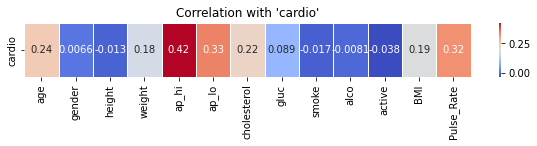

In [147]:
# preparing data to plot the heatmap diagram
attributes = list(correlations.keys())
correlation_values = list(correlations.values())
corr_matrix = [correlation_values]

# Generate the heatmap plot
plt.figure(figsize=(10, 1))  # Adjust size as per your preference
sns.heatmap(corr_matrix, annot=True, yticklabels=['cardio'], xticklabels=attributes, cmap="coolwarm", cbar=True, linewidths=0.5)
plt.title("Correlation with 'cardio'")
plt.show()

In [148]:
# separate the features and target
tmpDf = merge_df.drop("cardio")
feature_cols = tmpDf.columns

# Assemble features into a single vector column
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
df_assembled = assembler.transform(merge_df)

# Create and train a RandomForest model
rfCls = RandomForestClassifier(labelCol="cardio", featuresCol="features", numTrees=100)
model = rfCls.fit(df_assembled)

# Extract feature importances and sort them in descending order
importances = model.featureImportances.toArray()
sorted_indices = importances.argsort()[::-1] 

# Print the result
print("\nImportance Features")
print("------------------------------------")
for index in sorted_indices:
    print(f"{feature_cols[index]}: {importances[index]:.4f}")



Importance Features
------------------------------------
ap_hi: 0.4455
ap_lo: 0.2154
Pulse_Rate: 0.1695
cholesterol: 0.0774
age: 0.0710
BMI: 0.0111
weight: 0.0061
gluc: 0.0024
active: 0.0007
height: 0.0005
smoke: 0.0003
alco: 0.0002
gender: 0.0001


In [149]:
# Drop the columns which are less correlation/importance
merge_df = merge_df.drop("active", "height", "smoke", "alco", "gender")

merge_df.columns

['age',
 'weight',
 'ap_hi',
 'ap_lo',
 'cholesterol',
 'gluc',
 'cardio',
 'BMI',
 'Pulse_Rate']

In [150]:
tmpDf = merge_df.drop("cardio")
feature_cols = tmpDf.columns

# Compute and categorize skewness for each column
print("\nSkewness Values")
print("------------------------------------")
for column in feature_cols:
    skew_value = merge_df.select(skewness(column)).collect()[0][0]
    print(f"Skewness value for {column}: {skew_value:.4f}")



Skewness Values
------------------------------------
Skewness value for age: -0.3042
Skewness value for weight: 1.0454
Skewness value for ap_hi: 0.9155
Skewness value for ap_lo: 0.6647
Skewness value for cholesterol: 1.5947
Skewness value for gluc: 2.3981
Skewness value for BMI: 1.2111
Skewness value for Pulse_Rate: 0.5382


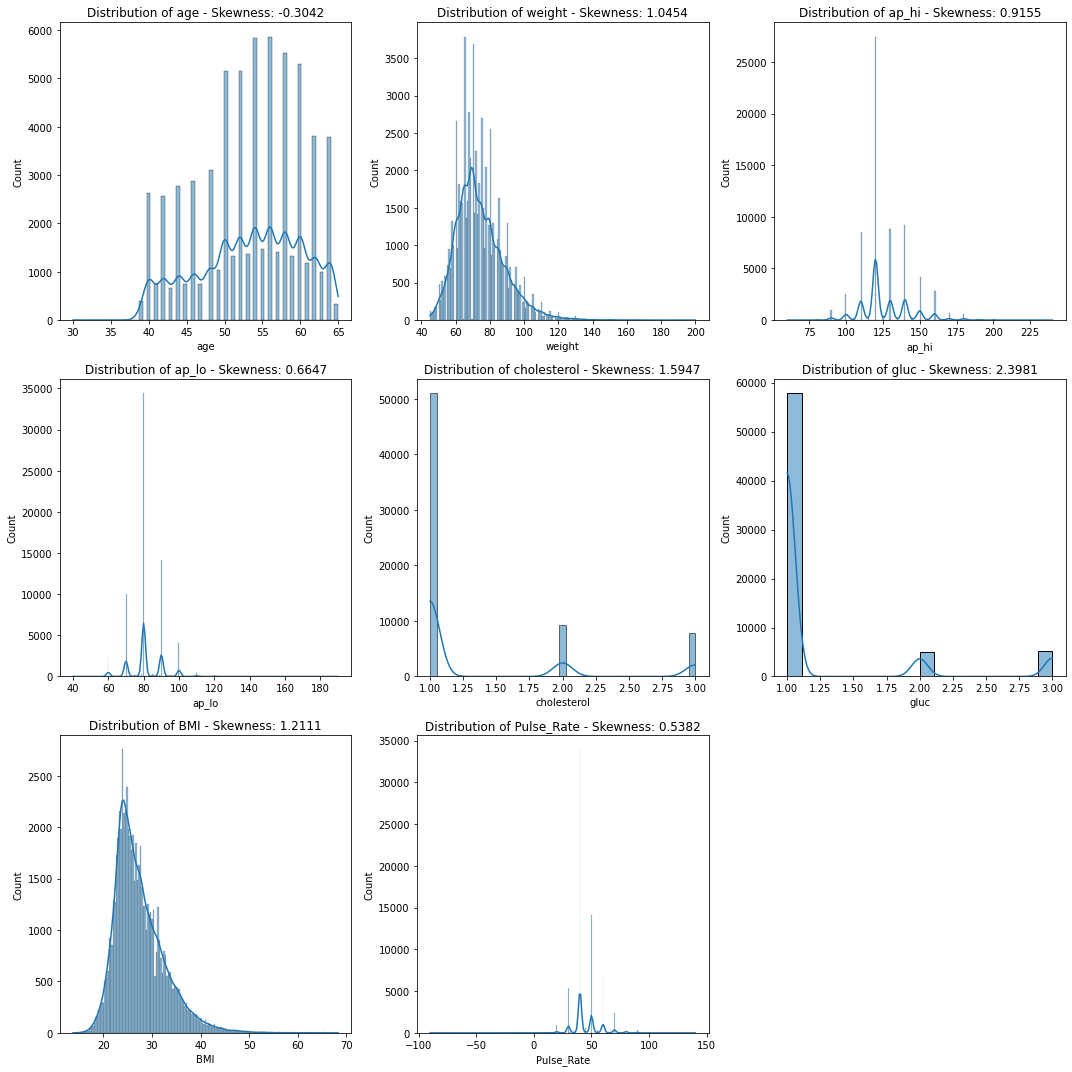

In [151]:
# Covert to Pandas
tmpDf_pd = tmpDf.toPandas()

# Setting up the subplot grid
num_features = len(feature_cols)
num_rows = (num_features + 2) // 3  # Ceiling division to ensure enough rows

plt.figure(figsize=(15, 5 * num_rows))
for idx, column in enumerate(feature_cols):
    # Setting the position for the subplot
    plt.subplot(num_rows, 3, idx+1)
    
    # Plotting distribution
    sns.histplot(tmpDf_pd[column], kde=True)
    
    # Computing and displaying skewness
    skew_value = merge_df.select(skewness(column)).collect()[0][0]
    plt.title(f"Distribution of {column} - Skewness: {skew_value:.4f}")

plt.tight_layout()  # Adjusting layout for better visualization
plt.show()

In [152]:
# Applying Inverse Transformation to 'gluc' column
merge_df = merge_df.withColumn("gluc", 1/merge_df["gluc"])

# Verify the transformed data
skew_value = merge_df.select(skewness("gluc")).collect()[0][0]
print(f"Skewness value for gluc: {skew_value:.4f}")

Skewness value for gluc: -2.0554


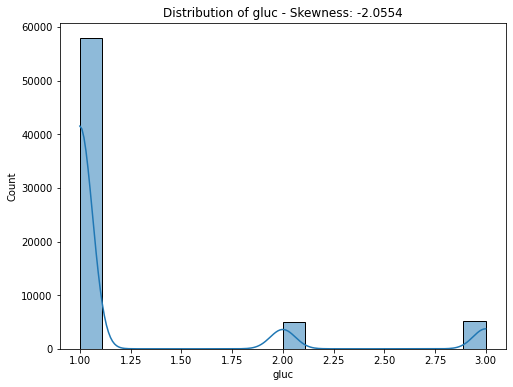

In [153]:
## Plotting the distribution for "BMI" feature
plt.figure(figsize=(8, 6))
sns.histplot(tmpDf_pd['gluc'], kde=True)
skew_value = merge_df.select(skewness('gluc')).collect()[0][0]
plt.title(f"Distribution of {'gluc'} - Skewness: {skew_value:.4f}")
plt.show()

# 5 - DMM

The detial information about DMM is addressed in Itertion-4 report Secion - 5

# 6 - DMA

In [154]:
# Segarate the Features and Target
feature_cols = merge_df.drop("cardio").columns

# Assemble features into a single vector column
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")

### Decision Tree Classifier

In [155]:
# Build Decision Tree Classifier
dtCls = DecisionTreeClassifier(labelCol='cardio',featuresCol='features')

pipeline = Pipeline(stages=[assembler, dtCls])
model = pipeline.fit(merge_df)
prediction = model.transform(merge_df)

In [156]:
# Evaluate model Accuracy
mulEvaluator = MulticlassClassificationEvaluator(labelCol="cardio", predictionCol="prediction", metricName="accuracy")
accuracy = mulEvaluator.evaluate(prediction)
print(f"\nDecision Tree Classifier - Accuracy = {accuracy:.2f}")

# Evaluate model using areaUnderROC
binaryEvaluator = BinaryClassificationEvaluator(labelCol="cardio", rawPredictionCol="rawPrediction", metricName="areaUnderROC")
roc_auc = binaryEvaluator.evaluate(prediction)
print(f"\nDecision Tree Classifier - Area Under ROC (AUC) = {roc_auc:.2f}")

# Evaluate model using areaUnderPR
binaryEvaluator.setMetricName("areaUnderPR")
pr_auc = binaryEvaluator.evaluate(prediction)
print(f"\nDecision Tree Classifier - Area Under PR = {pr_auc:.2f}")


Decision Tree Classifier - Accuracy = 0.73

Decision Tree Classifier - Area Under ROC (AUC) = 0.59

Decision Tree Classifier - Area Under PR = 0.67


In [157]:
# Generate Classification report 
print("\nDecision Tree Classifier - Classification Report: ")
print("-----------------------------------------------------")
classification_report(prediction)
print("-----------------------------------------------------")


Decision Tree Classifier - Classification Report: 
-----------------------------------------------------
              precision    recall  f1-score   support
           0  0.71         0.79    0.73       34363
           1  0.76         0.68    0.73       33763
    accuracy                       0.73       68126
   macro avg  0.73         0.73    0.73       68126
weighted avg  0.73         0.73    0.73       68126
-----------------------------------------------------


In [158]:
# Generate Confusion Matrix
print("\nDecision Tree Classifier - Confusion Matrix: ")
print("-----------------------------------------------------")
confusion_matrix(prediction)
print("-----------------------------------------------------")


Decision Tree Classifier - Confusion Matrix: 
-----------------------------------------------------
TN: 26980	FP: 7383
FN: 10938	TP: 22825
-----------------------------------------------------


In [159]:
# Generate Predictor Feature Importance
print("\nDecision Tree Classifier - Predictor Feature Importance: ")
print("-----------------------------------------------------")
feature_importance(model.stages[-1], feature_cols)
print("-----------------------------------------------------")


Decision Tree Classifier - Predictor Feature Importance: 
-----------------------------------------------------
Feature: ap_hi, Importance: 0.8015
Feature: age, Importance: 0.1111
Feature: cholesterol, Importance: 0.0754
Feature: gluc, Importance: 0.0050
Feature: Pulse_Rate, Importance: 0.0042
Feature: BMI, Importance: 0.0029
Feature: weight, Importance: 0.0000
Feature: ap_lo, Importance: 0.0000
-----------------------------------------------------


### Random Forest Classifier

In [160]:
# Build Random Forest Classifier
rfCls = RandomForestClassifier(labelCol='cardio',featuresCol='features')

pipeline = Pipeline(stages=[assembler, rfCls])
model = pipeline.fit(merge_df)
prediction = model.transform(merge_df)

In [161]:
# Evaluate model Accuracy
mulEvaluator = MulticlassClassificationEvaluator(labelCol="cardio", predictionCol="prediction", metricName="accuracy")
accuracy = mulEvaluator.evaluate(prediction)
print(f"\nRandom Forest Classifier - Accuracy = {accuracy:.2f}")

# Evaluate model using areaUnderROC
binaryEvaluator = BinaryClassificationEvaluator(labelCol="cardio", rawPredictionCol="rawPrediction", metricName="areaUnderROC")
roc_auc = binaryEvaluator.evaluate(prediction)
print(f"\nRandom Forest Classifier - Area Under ROC (AUC) = {roc_auc:.2f}")

# Evaluate model using areaUnderPR
binaryEvaluator.setMetricName("areaUnderPR")
pr_auc = binaryEvaluator.evaluate(prediction)
print(f"\nRandom Forest Classifier - Area Under PR = {pr_auc:.2f}")


Random Forest Classifier - Accuracy = 0.73

Random Forest Classifier - Area Under ROC (AUC) = 0.79

Random Forest Classifier - Area Under PR = 0.78


In [162]:
# Generate Classification report 
print("\nRandom Forest Classifier - Classification Report: ")
print("-----------------------------------------------------")
classification_report(prediction)
print("-----------------------------------------------------")


Random Forest Classifier - Classification Report: 
-----------------------------------------------------


              precision    recall  f1-score   support
           0  0.70         0.79    0.73       34363
           1  0.76         0.66    0.73       33763
    accuracy                       0.73       68126
   macro avg  0.73         0.73    0.73       68126
weighted avg  0.73         0.73    0.73       68126
-----------------------------------------------------


In [163]:
# Generate Confusion Matrix
print("\nRandom Forest Classifier - Confusion Matrix: ")
print("-----------------------------------------------------")
confusion_matrix(prediction)
print("-----------------------------------------------------")


Random Forest Classifier - Confusion Matrix: 
-----------------------------------------------------
TN: 27167	FP: 7196
FN: 11455	TP: 22308
-----------------------------------------------------


In [164]:
# Generate Predictor Feature Importance
print("\nRandom Forest Classifier - Predictor Feature Importance: ")
print("-----------------------------------------------------")
feature_importance(model.stages[-1], feature_cols)
print("-----------------------------------------------------")


Random Forest Classifier - Predictor Feature Importance: 
-----------------------------------------------------
Feature: ap_hi, Importance: 0.3956
Feature: Pulse_Rate, Importance: 0.2100
Feature: ap_lo, Importance: 0.2090
Feature: age, Importance: 0.0942
Feature: cholesterol, Importance: 0.0733
Feature: BMI, Importance: 0.0133
Feature: weight, Importance: 0.0024
Feature: gluc, Importance: 0.0021
-----------------------------------------------------


### Gradient-Boosted Tree Classifier

In [165]:
# Build Gradient-Boosted Tree Classifier
gbtCls = GBTClassifier(labelCol='cardio',featuresCol='features')

pipeline = Pipeline(stages=[assembler, gbtCls])
model = pipeline.fit(merge_df)
prediction = model.transform(merge_df)

In [166]:
# Evaluate model Accuracy
mulEvaluator = MulticlassClassificationEvaluator(labelCol="cardio", predictionCol="prediction", metricName="accuracy")
accuracy = mulEvaluator.evaluate(prediction)
print(f"\nGradient-Boosted Tree Classifier - Accuracy = {accuracy:.2f}")

# Evaluate model using areaUnderROC
binaryEvaluator = BinaryClassificationEvaluator(labelCol="cardio", rawPredictionCol="rawPrediction", metricName="areaUnderROC")
roc_auc = binaryEvaluator.evaluate(prediction)
print(f"\nGradient-Boosted Tree Classifier - Area Under ROC (AUC) = {roc_auc:.2f}")

# Evaluate model using areaUnderPR
binaryEvaluator.setMetricName("areaUnderPR")
pr_auc = binaryEvaluator.evaluate(prediction)
print(f"\nGradient-Boosted Tree Classifier - Area Under PR = {pr_auc:.2f}")


Gradient-Boosted Tree Classifier - Accuracy = 0.74

Gradient-Boosted Tree Classifier - Area Under ROC (AUC) = 0.80

Gradient-Boosted Tree Classifier - Area Under PR = 0.79


In [167]:
# Generate Classification report 
print("\nGradient-Boosted Tree Classifier - Classification Report: ")
print("-----------------------------------------------------")
classification_report(prediction)
print("-----------------------------------------------------")


Gradient-Boosted Tree Classifier - Classification Report: 
-----------------------------------------------------


              precision    recall  f1-score   support
           0  0.72         0.78    0.73       34363
           1  0.76         0.69    0.73       33763
    accuracy                       0.74       68126
   macro avg  0.74         0.73    0.73       68126
weighted avg  0.74         0.74    0.73       68126
-----------------------------------------------------


In [168]:
# Generate Confusion Matrix
print("\nGradient-Boosted Tree Classifier - Confusion Matrix: ")
print("-----------------------------------------------------")
confusion_matrix(prediction)
print("-----------------------------------------------------")


Gradient-Boosted Tree Classifier - Confusion Matrix: 
-----------------------------------------------------
TN: 26888	FP: 7475
FN: 10555	TP: 23208
-----------------------------------------------------


In [169]:
# Generate Predictor Feature Importance
print("\nGradient-Boosted Tree Classifier - Predictor Feature Importance: ")
print("-----------------------------------------------------")
feature_importance(model.stages[-1], feature_cols)
print("-----------------------------------------------------")


Gradient-Boosted Tree Classifier - Predictor Feature Importance: 
-----------------------------------------------------
Feature: ap_hi, Importance: 0.4909
Feature: age, Importance: 0.1676
Feature: BMI, Importance: 0.0859
Feature: cholesterol, Importance: 0.0771
Feature: ap_lo, Importance: 0.0733
Feature: weight, Importance: 0.0663
Feature: Pulse_Rate, Importance: 0.0200
Feature: gluc, Importance: 0.0189
-----------------------------------------------------


### Hyperparameter tuning 

In [170]:
# Split the data into training and test sets (70% train, 30% test)
train_data, test_data = merge_df.randomSplit([0.7, 0.3])

In [171]:
# Gradient-Boosted Tree Classifier Hyperparameter tuning
maxDepths = [3, 5, 7]
learningRates = [0.01, 0.05, 0.1]
combinations = [(depth, rate) for depth in maxDepths for rate in learningRates]

evaluator = BinaryClassificationEvaluator(labelCol="cardio")

best_metric = float('-inf')
best_model = None
best_params = (None, None)

for depth, rate in combinations:
    cls = GBTClassifier(labelCol='cardio', featuresCol='features', maxDepth=depth, stepSize=rate)
    pipeline = Pipeline(stages=[assembler, cls])
    model = pipeline.fit(train_data)
    prediction = model.transform(test_data)
    metric = evaluator.evaluate(prediction)
    
    if metric > best_metric:
        best_metric = metric
        best_model = model
        best_params = (depth, rate)

print(f"Best Parameters: Max Depth = {best_params[0]}, Step Size = {best_params[1]}")

Best Parameters: Max Depth = 5, Step Size = 0.1


In [172]:
# Random Forest Classifier Hyperparameter tuning
maxDepths = [5, 10, 15]
maxBins = [32, 64]

combinations = [(depth, bins) for depth in maxDepths for bins in maxBins]

evaluator = BinaryClassificationEvaluator(labelCol="cardio")

best_metric = float('-inf')
best_model = None
best_params = (None, None, None)

for depth, bins in combinations:
    cls = RandomForestClassifier(labelCol='cardio', featuresCol='features', maxDepth=depth, maxBins=bins)
    pipeline = Pipeline(stages=[assembler, cls])
    model = pipeline.fit(train_data)
    prediction = model.transform(test_data)
    metric = evaluator.evaluate(prediction)
    
    if metric > best_metric:
        best_metric = metric
        best_model = model
        best_params = (depth, bins)

print(f"Best Parameters: Max Depth = {best_params[0]}, Max Bins = {best_params[1]}")

Best Parameters: Max Depth = 10, Max Bins = 32


# 7 - DM

### Creating Train & Test Datasets (70% 30%)

In [173]:
# Split the data into training and test sets (70% train, 30% test)
train_data, test_data = merge_df.randomSplit([0.7, 0.3])

### Gradient-Boosted Tree Classifier

In [174]:
# Build the Gradient-Boosted Tree Classifier with best hyperparameter
gbtCls = GBTClassifier(labelCol='cardio', featuresCol='features', maxDepth=5, stepSize=0.1)
pipeline = Pipeline(stages=[assembler, rfCls])
model = pipeline.fit(train_data)
prediction = model.transform(test_data)
metric = evaluator.evaluate(prediction)

In [175]:
# Evaluate model Accuracy
mulEvaluator = MulticlassClassificationEvaluator(labelCol="cardio", predictionCol="prediction", metricName="accuracy")
accuracy = mulEvaluator.evaluate(prediction)
print(f"\nGradient-Boosted Tree Classifier - Accuracy = {accuracy:.2f}")

# Evaluate model using areaUnderROC
binaryEvaluator = BinaryClassificationEvaluator(labelCol="cardio", rawPredictionCol="rawPrediction", metricName="areaUnderROC")
roc_auc = binaryEvaluator.evaluate(prediction)
print(f"\nGradient-Boosted Tree Classifier - Area Under ROC (AUC) = {roc_auc:.2f}")

# Evaluate model using areaUnderPR
binaryEvaluator.setMetricName("areaUnderPR")
pr_auc = binaryEvaluator.evaluate(prediction)
print(f"\nGradient-Boosted Tree Classifier - Area Under PR = {pr_auc:.2f}")


Gradient-Boosted Tree Classifier - Accuracy = 0.73

Gradient-Boosted Tree Classifier - Area Under ROC (AUC) = 0.79

Gradient-Boosted Tree Classifier - Area Under PR = 0.77


In [176]:
# Generate Classification report 
print("\nGradient-Boosted Tree Classifier - Classification Report: ")
print("-----------------------------------------------------")
classification_report(prediction)
print("-----------------------------------------------------")


Gradient-Boosted Tree Classifier - Classification Report: 
-----------------------------------------------------
              precision    recall  f1-score   support
           0  0.70         0.80    0.73       10335
           1  0.76         0.66    0.73       10126
    accuracy                       0.73       20461
   macro avg  0.73         0.73    0.73       20461
weighted avg  0.73         0.73    0.73       20461
-----------------------------------------------------


In [177]:
# Generate Confusion Matrix
print("\nGradient-Boosted Tree Classifier - Confusion Matrix: ")
print("-----------------------------------------------------")
confusion_matrix(prediction)
print("-----------------------------------------------------")


Gradient-Boosted Tree Classifier - Confusion Matrix: 
-----------------------------------------------------
TN: 8250	FP: 2085
FN: 3456	TP: 6670
-----------------------------------------------------


In [178]:
# Generate Predictor Feature Importance
print("\nGradient-Boosted Tree Classifier - Predictor Feature Importance: ")
print("-----------------------------------------------------")
feature_importance(model.stages[-1], feature_cols)
print("-----------------------------------------------------")


Gradient-Boosted Tree Classifier - Predictor Feature Importance: 
-----------------------------------------------------
Feature: ap_hi, Importance: 0.4054
Feature: Pulse_Rate, Importance: 0.2252
Feature: ap_lo, Importance: 0.1760
Feature: age, Importance: 0.1089
Feature: cholesterol, Importance: 0.0685
Feature: BMI, Importance: 0.0117
Feature: weight, Importance: 0.0032
Feature: gluc, Importance: 0.0011
-----------------------------------------------------


### Random Forest Classifier

In [179]:
# Build the Random Forest Classifier with best hyperparameter
rfCls = RandomForestClassifier(labelCol='cardio', featuresCol='features', maxDepth=10, maxBins=64)
pipeline = Pipeline(stages=[assembler, rfCls])
model = pipeline.fit(train_data)
prediction = model.transform(test_data)
metric = evaluator.evaluate(prediction)

In [180]:
# Evaluate model Accuracy
mulEvaluator = MulticlassClassificationEvaluator(labelCol="cardio", predictionCol="prediction", metricName="accuracy")
accuracy = mulEvaluator.evaluate(prediction)
print(f"\nRandom Forest Classifier - Accuracy = {accuracy:.2f}")

# Evaluate model using areaUnderROC
binaryEvaluator = BinaryClassificationEvaluator(labelCol="cardio", rawPredictionCol="rawPrediction", metricName="areaUnderROC")
roc_auc = binaryEvaluator.evaluate(prediction)
print(f"\nRandom Forest Classifier - Area Under ROC (AUC) = {roc_auc:.2f}")

# Evaluate model using areaUnderPR
binaryEvaluator.setMetricName("areaUnderPR")
pr_auc = binaryEvaluator.evaluate(prediction)
print(f"\nRandom Forest Classifier - Area Under PR = {pr_auc:.2f}")


Random Forest Classifier - Accuracy = 0.73

Random Forest Classifier - Area Under ROC (AUC) = 0.80

Random Forest Classifier - Area Under PR = 0.78


In [181]:
# Generate Classification report 
print("\nRandom Forest Classifier - Classification Report: ")
print("-----------------------------------------------------")
classification_report(prediction)
print("-----------------------------------------------------")


Random Forest Classifier - Classification Report: 
-----------------------------------------------------


              precision    recall  f1-score   support
           0  0.72         0.78    0.73       10335
           1  0.75         0.69    0.73       10126
    accuracy                       0.73       20461
   macro avg  0.73         0.73    0.73       20461
weighted avg  0.73         0.73    0.73       20461
-----------------------------------------------------


In [182]:
# Generate Confusion Matrix
print("\nRandom Forest Classifier - Confusion Matrix: ")
print("-----------------------------------------------------")
confusion_matrix(prediction)
print("-----------------------------------------------------")


Random Forest Classifier - Confusion Matrix: 
-----------------------------------------------------
TN: 8024	FP: 2311
FN: 3151	TP: 6975
-----------------------------------------------------


In [183]:
# Generate Predictor Feature Importance
print("\nRandom Forest Classifier - Predictor Feature Importance: ")
print("-----------------------------------------------------")
feature_importance(model.stages[-1], feature_cols)
print("-----------------------------------------------------")


Random Forest Classifier - Predictor Feature Importance: 
-----------------------------------------------------
Feature: ap_hi, Importance: 0.3395
Feature: Pulse_Rate, Importance: 0.1878
Feature: ap_lo, Importance: 0.1577
Feature: age, Importance: 0.1379
Feature: cholesterol, Importance: 0.0764
Feature: BMI, Importance: 0.0493
Feature: weight, Importance: 0.0389
Feature: gluc, Importance: 0.0126
-----------------------------------------------------


# 8 - INT

### Visualising

In [184]:
print("\n Cardio vs Gender")
print("------------------------------------")
# 'Cardio vs Gender'
df.groupBy('cardio', 'gender').agg(count('*').alias('Count')).show()

print("\n Cardio vs Active")
print("------------------------------------")
# 'Cardio vs active'
df.groupBy('cardio','active').agg(count('*').alias('Count')).show()

print("\n Cardio vs Smoke")
print("------------------------------------")
# 'Cardio vs smoke'
df.groupBy('cardio', 'smoke').agg(count('*').alias('Count')).show()

print("\n Cardio vs Alco")
print("------------------------------------")
# 'Cardio vs alco'
df.groupBy('cardio', 'alco').agg(count('*').alias('Count')).show()


 Cardio vs Gender
------------------------------------
+------+------+-----+
|cardio|gender|Count|
+------+------+-----+
|     1|     2|11796|
|     1|     1|21487|
|     0|     1|22100|
|     0|     2|11774|
+------+------+-----+


 Cardio vs Active
------------------------------------
+------+------+-----+
|cardio|active|Count|
+------+------+-----+
|     1|     0| 7033|
|     1|     1|26250|
|     0|     0| 6161|
|     0|     1|27713|
+------+------+-----+


 Cardio vs Smoke
------------------------------------
+------+-----+-----+
|cardio|smoke|Count|
+------+-----+-----+
|     1|    0|30491|
|     1|    1| 2792|
|     0|    0|30710|
|     0|    1| 3164|
+------+-----+-----+


 Cardio vs Alco
------------------------------------
+------+----+-----+
|cardio|alco|Count|
+------+----+-----+
|     1|   0|31553|
|     1|   1| 1730|
|     0|   0|31983|
|     0|   1| 1891|
+------+----+-----+



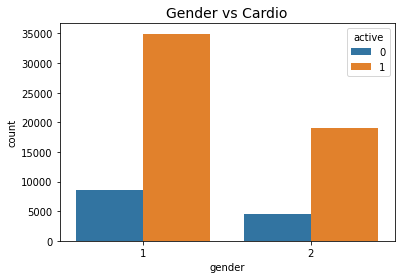

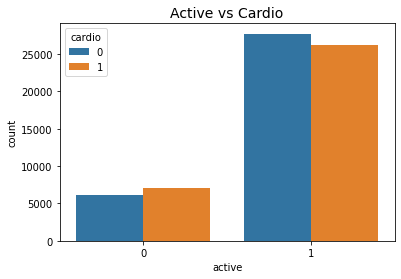

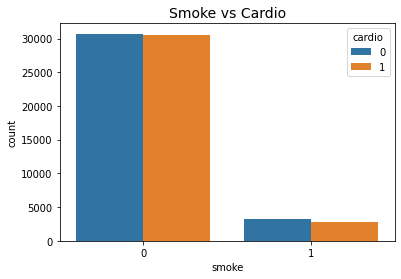

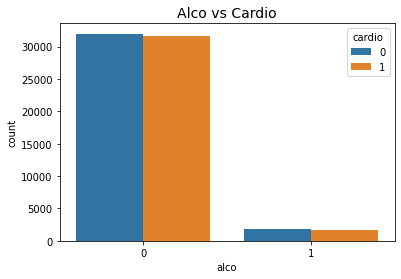

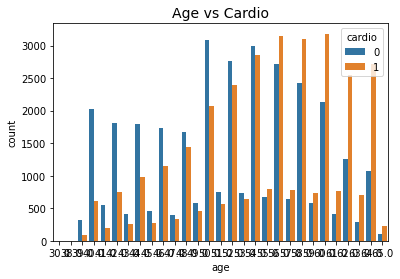

In [185]:
# Plotting 'Cardio vs active'
df_pd = df.toPandas()
sns.countplot(x='gender', hue='active', data=df_pd)
plt.title("Gender vs Cardio", size=14)
plt.show()

# Plotting 'Cardio vs smoke'
sns.countplot(x='active', hue='cardio', data=df_pd)
plt.title("Active vs Cardio", size=14)
plt.show()

# Plotting 'Cardio vs smoke'
sns.countplot(x='smoke', hue='cardio', data=df_pd)
plt.title("Smoke vs Cardio", size=14)
plt.show()

# Plotting 'Cardio vs alco'
sns.countplot(x='alco', hue='cardio', data=df_pd)
plt.title("Alco vs Cardio", size=14)
plt.show()

# Plotting 'Cardio vs Age'
df_pd = merge_df.toPandas()
sns.countplot(x='age', hue='cardio', data=df_pd)
plt.title("Age vs Cardio", size=14)
plt.show()


Correlation Results
------------------------------------
Correlation between "cardio" and "ap_hi": 0.4243
Correlation between "cardio" and "ap_lo": 0.3340
Correlation between "cardio" and "Pulse_Rate": 0.3182
Correlation between "cardio" and "age": 0.2386
Correlation between "cardio" and "cholesterol": 0.2212
Correlation between "cardio" and "BMI": 0.1900
Correlation between "cardio" and "weight": 0.1787
Correlation between "cardio" and "gluc": -0.0915


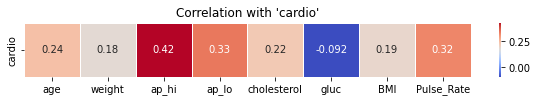

In [186]:
# prepare the columns
tmpDf = merge_df.drop("cardio")
columns = tmpDf.columns
target = 'cardio'

# apply correlation method
correlations = {}
for col in columns:
    corr_value = merge_df.stat.corr(col, target)
    correlations[col] = corr_value

# print the result in descending order
print("\nCorrelation Results")
print("------------------------------------")
sorted_correlations = sorted(correlations.items(), key=lambda x: x[1], reverse=True)
for col, corr_value in sorted_correlations:
    print(f"Correlation between \"{target}\" and \"{col}\": {corr_value:.4f}")


# preparing data to plot the heatmap diagram
attributes = list(correlations.keys())
correlation_values = list(correlations.values())
corr_matrix = [correlation_values]

# Generate the heatmap plot
plt.figure(figsize=(10, 1))  # Adjust size as per your preference
sns.heatmap(corr_matrix, annot=True, yticklabels=['cardio'], xticklabels=attributes, cmap="coolwarm", cbar=True, linewidths=0.5)
plt.title("Correlation with 'cardio'")
plt.show()


Skewness Values
------------------------------------
Skewness value for age: -0.3042
Skewness value for weight: 1.0454
Skewness value for ap_hi: 0.9155
Skewness value for ap_lo: 0.6647
Skewness value for cholesterol: 1.5947
Skewness value for gluc: -2.0554
Skewness value for BMI: 1.2111
Skewness value for Pulse_Rate: 0.5382


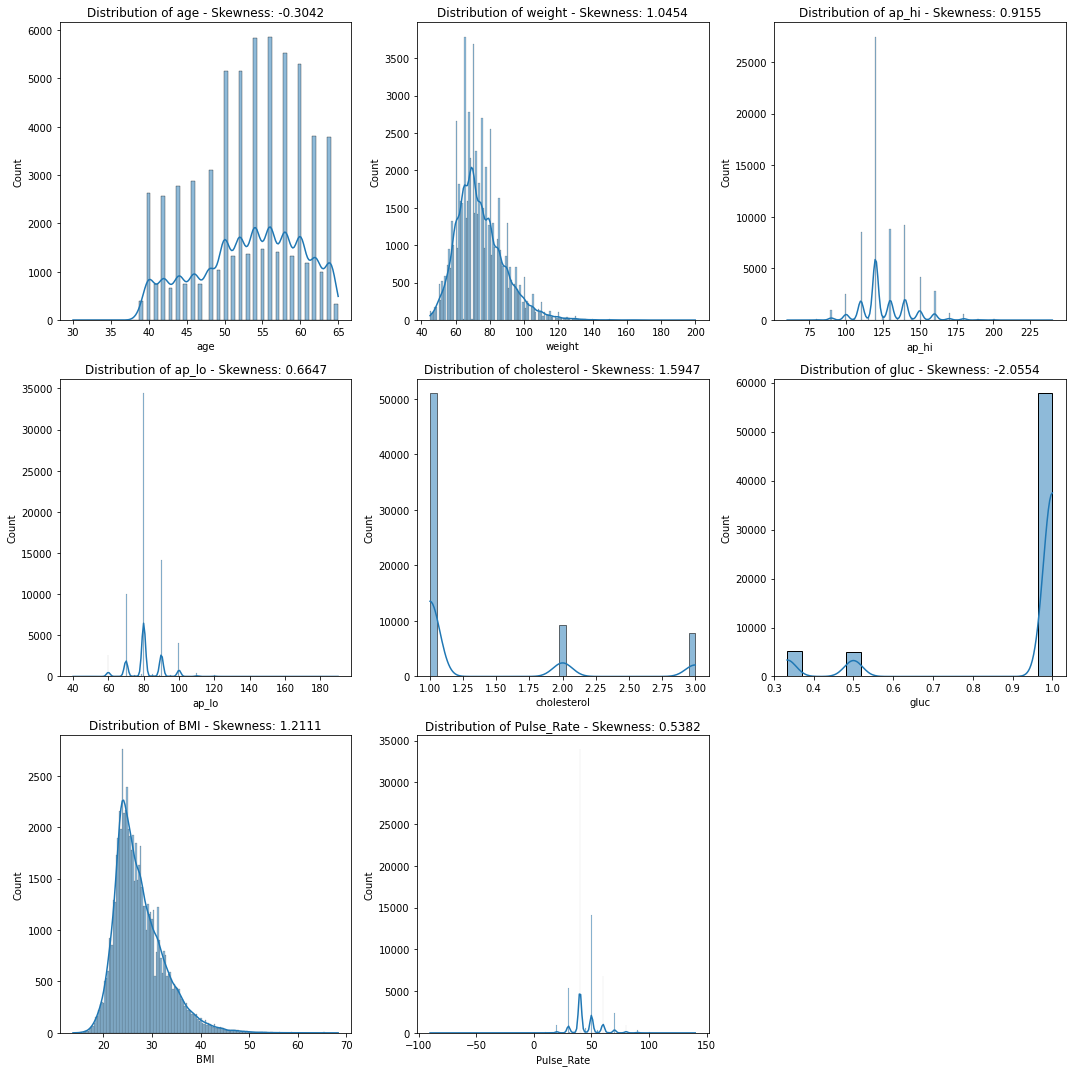

In [187]:
# Compute and categorize skewness for each column
tmpDf = merge_df.drop("cardio")
feature_cols = tmpDf.columns
print("\nSkewness Values")
print("------------------------------------")
for column in feature_cols:
    skew_value = merge_df.select(skewness(column)).collect()[0][0]
    print(f"Skewness value for {column}: {skew_value:.4f}")
	
# Covert to Pandas
tmpDf_pd = tmpDf.toPandas()

# Setting up the subplot grid
num_features = len(feature_cols)
num_rows = (num_features + 2) // 3  # Ceiling division to ensure enough rows

plt.figure(figsize=(15, 5 * num_rows))
for idx, column in enumerate(feature_cols):
    # Setting the position for the subplot
    plt.subplot(num_rows, 3, idx+1)
    
    # Plotting distribution
    sns.histplot(tmpDf_pd[column], kde=True)
    
    # Computing and displaying skewness
    skew_value = merge_df.select(skewness(column)).collect()[0][0]
    plt.title(f"Distribution of {column} - Skewness: {skew_value:.4f}")

plt.tight_layout()  # Adjusting layout for better visualization
plt.show()

In [188]:
# Build the Gradient-Boosted Tree Classifier with best hyperparameter
gbtCls = GBTClassifier(labelCol='cardio', featuresCol='features', maxDepth=5, stepSize=0.1)
pipeline = Pipeline(stages=[assembler, rfCls])
model = pipeline.fit(train_data)
prediction = model.transform(test_data)
metric = evaluator.evaluate(prediction)

# Evaluate model Accuracy
mulEvaluator = MulticlassClassificationEvaluator(labelCol="cardio", predictionCol="prediction", metricName="accuracy")
accuracy = mulEvaluator.evaluate(prediction)
print(f"\nGradient-Boosted Tree Classifier - Accuracy = {accuracy:.2f}")

# Evaluate model using areaUnderROC
binaryEvaluator = BinaryClassificationEvaluator(labelCol="cardio", rawPredictionCol="rawPrediction", metricName="areaUnderROC")
roc_auc = binaryEvaluator.evaluate(prediction)
print(f"\nGradient-Boosted Tree Classifier - Area Under ROC (AUC) = {roc_auc:.2f}")

# Evaluate model using areaUnderPR
binaryEvaluator.setMetricName("areaUnderPR")
pr_auc = binaryEvaluator.evaluate(prediction)
print(f"\nGradient-Boosted Tree Classifier - Area Under PR = {pr_auc:.2f}")

# Generate Classification report 
print("\nGradient-Boosted Tree Classifier - Classification Report: ")
print("-----------------------------------------------------")
classification_report(prediction)
print("-----------------------------------------------------")

# Generate Confusion Matrix
print("\nGradient-Boosted Tree Classifier - Confusion Matrix: ")
print("-----------------------------------------------------")
confusion_matrix(prediction)
print("-----------------------------------------------------")

# Generate Predictor Feature Importance
print("\nGradient-Boosted Tree Classifier - Predictor Feature Importance: ")
print("-----------------------------------------------------")
feature_importance(model.stages[-1], feature_cols)
print("-----------------------------------------------------")


Gradient-Boosted Tree Classifier - Accuracy = 0.73

Gradient-Boosted Tree Classifier - Area Under ROC (AUC) = 0.80

Gradient-Boosted Tree Classifier - Area Under PR = 0.78

Gradient-Boosted Tree Classifier - Classification Report: 
-----------------------------------------------------
              precision    recall  f1-score   support
           0  0.72         0.78    0.73       10335
           1  0.75         0.69    0.73       10126
    accuracy                       0.73       20461
   macro avg  0.73         0.73    0.73       20461
weighted avg  0.73         0.73    0.73       20461
-----------------------------------------------------

Gradient-Boosted Tree Classifier - Confusion Matrix: 
-----------------------------------------------------
TN: 8024	FP: 2311
FN: 3151	TP: 6975
-----------------------------------------------------

Gradient-Boosted Tree Classifier - Predictor Feature Importance: 
-----------------------------------------------------
Feature: ap_hi, Importanc

In [189]:
# Build the Random Forest Classifier with best hyperparameter
rfCls = RandomForestClassifier(labelCol='cardio', featuresCol='features', maxDepth=10, maxBins=64)
pipeline = Pipeline(stages=[assembler, rfCls])
model = pipeline.fit(train_data)
prediction = model.transform(test_data)
metric = evaluator.evaluate(prediction)

# Evaluate model Accuracy
mulEvaluator = MulticlassClassificationEvaluator(labelCol="cardio", predictionCol="prediction", metricName="accuracy")
accuracy = mulEvaluator.evaluate(prediction)
print(f"\nRandom Forest Classifier - Accuracy = {accuracy:.2f}")

# Evaluate model using areaUnderROC
binaryEvaluator = BinaryClassificationEvaluator(labelCol="cardio", rawPredictionCol="rawPrediction", metricName="areaUnderROC")
roc_auc = binaryEvaluator.evaluate(prediction)
print(f"\nRandom Forest Classifier - Area Under ROC (AUC) = {roc_auc:.2f}")

# Evaluate model using areaUnderPR
binaryEvaluator.setMetricName("areaUnderPR")
pr_auc = binaryEvaluator.evaluate(prediction)
print(f"\nRandom Forest Classifier - Area Under PR = {pr_auc:.2f}")

# Generate Classification report 
print("\nRandom Forest Classifier - Classification Report: ")
print("-----------------------------------------------------")
classification_report(prediction)
print("-----------------------------------------------------")

# Generate Confusion Matrix
print("\nRandom Forest Classifier - Confusion Matrix: ")
print("-----------------------------------------------------")
confusion_matrix(prediction)
print("-----------------------------------------------------")

# Generate Predictor Feature Importance
print("\nRandom Forest Classifier - Predictor Feature Importance: ")
print("-----------------------------------------------------")
feature_importance(model.stages[-1], feature_cols)
print("-----------------------------------------------------")


Random Forest Classifier - Accuracy = 0.73

Random Forest Classifier - Area Under ROC (AUC) = 0.80

Random Forest Classifier - Area Under PR = 0.78

Random Forest Classifier - Classification Report: 
-----------------------------------------------------


              precision    recall  f1-score   support
           0  0.72         0.78    0.73       10335
           1  0.75         0.69    0.73       10126
    accuracy                       0.73       20461
   macro avg  0.73         0.73    0.73       20461
weighted avg  0.73         0.73    0.73       20461
-----------------------------------------------------

Random Forest Classifier - Confusion Matrix: 
-----------------------------------------------------
TN: 8024	FP: 2311
FN: 3151	TP: 6975
-----------------------------------------------------

Random Forest Classifier - Predictor Feature Importance: 
-----------------------------------------------------
Feature: ap_hi, Importance: 0.3395
Feature: Pulse_Rate, Importance: 0.1878
Feature: ap_lo, Importance: 0.1577
Feature: age, Importance: 0.1379
Feature: cholesterol, Importance: 0.0764
Feature: BMI, Importance: 0.0493
Feature: weight, Importance: 0.0389
Feature: gluc, Importance: 0.0126
-----------------------------------------

### Iteration-1 – Partition Data Size 80% of Training and 20% of Testing

In [190]:
# Split the data into training and test sets (80% train, 20% test)
train_data, test_data = merge_df.randomSplit([0.8, 0.2])

In [191]:
# Build the Gradient-Boosted Tree Classifier with best hyperparameter
gbtCls = GBTClassifier(labelCol='cardio', featuresCol='features', maxDepth=5, stepSize=0.1)
pipeline = Pipeline(stages=[assembler, rfCls])
model = pipeline.fit(train_data)
prediction = model.transform(test_data)

# Generate Classification report 
print("\nGradient-Boosted Tree Classifier - Classification Report: ")
print("-----------------------------------------------------")
classification_report(prediction)
print("-----------------------------------------------------")


Gradient-Boosted Tree Classifier - Classification Report: 
-----------------------------------------------------


              precision    recall  f1-score   support
           0  0.72         0.78    0.73       6926
           1  0.75         0.69    0.73       6706
    accuracy                       0.73       13632
   macro avg  0.73         0.73    0.73       13632
weighted avg  0.73         0.73    0.73       13632
-----------------------------------------------------


In [192]:
# Build the Random Forest Classifier with best hyperparameter
rfCls = RandomForestClassifier(labelCol='cardio', featuresCol='features', maxDepth=10, maxBins=64)
pipeline = Pipeline(stages=[assembler, rfCls])
model = pipeline.fit(train_data)
prediction = model.transform(test_data)

# Generate Classification report 
print("\nRandom Forest Classifier - Classification Report: ")
print("-----------------------------------------------------")
classification_report(prediction)
print("-----------------------------------------------------")


Random Forest Classifier - Classification Report: 
-----------------------------------------------------
              precision    recall  f1-score   support
           0  0.72         0.78    0.73       6926
           1  0.75         0.69    0.73       6706
    accuracy                       0.73       13632
   macro avg  0.73         0.73    0.73       13632
weighted avg  0.73         0.73    0.73       13632
-----------------------------------------------------


### Iteration-2 – “Decision Tree Classifier” Model

In [193]:
# Build Decision Tree Classifier
dtCls = DecisionTreeClassifier(labelCol='cardio',featuresCol='features')
pipeline = Pipeline(stages=[assembler, dtCls])
model = pipeline.fit(train_data)
prediction = model.transform(test_data)

# Generate Classification report 
print("\nDecision Tree Classifier - Classification Report: ")
print("-----------------------------------------------------")
classification_report(prediction)
print("-----------------------------------------------------")


Decision Tree Classifier - Classification Report: 
-----------------------------------------------------
              precision    recall  f1-score   support
           0  0.71         0.78    0.73       6926
           1  0.75         0.67    0.73       6706
    accuracy                       0.73       13632
   macro avg  0.73         0.73    0.73       13632
weighted avg  0.73         0.73    0.73       13632
-----------------------------------------------------


# 9 - ACT

Desribe the Action Plan to Implement, Observe and Improve